In [ ]:
%reset

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# import colormaps as cmaps
# plt.register_cmap(name='viridis', cmap=cmaps.viridis)
# plt.set_cmap(cmaps.viridis)

In [54]:
import brain_clusters
import os
import pandas as pd
import numpy as np
import pandas as pd
import scipy.io as spio

import cPickle as pickle
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import MultiComparison
import glob

from scipy import stats
from fdr_correct import fdr2
import seaborn as sns

In [ ]:
sns.set(style='white',context ='paper')


In [55]:
def get_ROI(subj, e, brain_ROI):
    """
    given a subj, elec and brain_ROI dictionary will return the ROI associated with the electrode
    """
    try:
        rois = brain_ROI[subj]
    except:
        return None
    else:
        for roi, elecs in rois.iteritems():
            if np.in1d(e, elecs):
                return roi

In [58]:
from loadmat import loadmat
#datafile = os.path.join('/Users/matar/Documents/PYTHON/brain_ROI.mat')
datafile = '/home/knight/matar/MATLAB/DATA/Avgusta/ROIs/brain_ROI.mat'
data = loadmat(datafile)
brain_ROI = data['brain_ROI']

In [59]:
#reconlist = os.path.join('/Users/matar/Documents/PYTHON/reconlist.csv')
reconlist = '/home/knight/matar/MATLAB/DATA/Avgusta/PCA/reconlist.csv'
reconlist = pd.read_csv(reconlist)

# anova, hsd in loop

## per each dataset

skipping JH10 EmoRep - not enough elecs for ANOVA
skipping JH10 SelfAud - not enough elecs for ANOVA
skipping HSD plot JH17 EmoRep
skipping HSD plot JH17 SelfAud
skipping JH17 SelfVis - not enough elecs for ANOVA
skipping HSD plot JH2 FaceEmo
skipping HSD plot JH6 FaceEmo
skipping ST1 EmoRep - not enough elecs for ANOVA
skipping ST1 SelfAud - not enough elecs for ANOVA
skipping ST6 SelfAud - not enough elecs for ANOVA
skipping ST6 SelfVis - not enough elecs for ANOVA


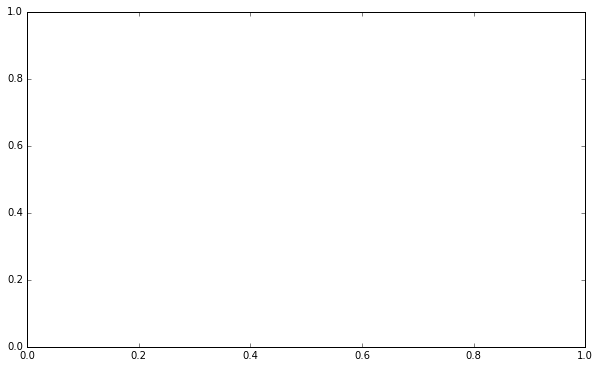

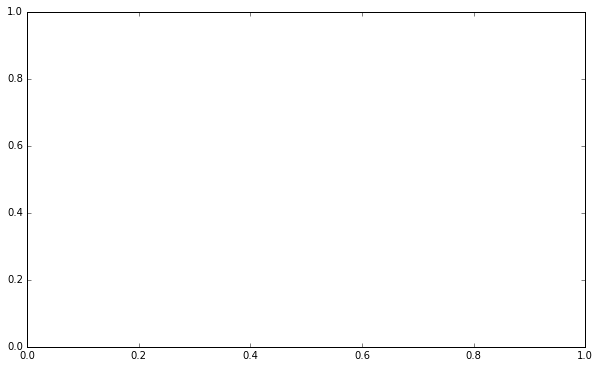

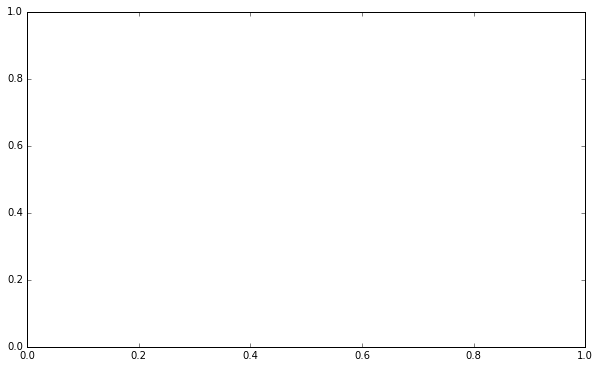

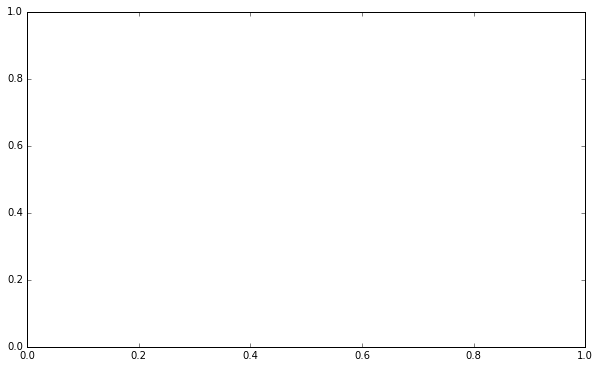

In [261]:
subj_task_list = reconlist.subj_task.apply(lambda x: x.split('_')).values
f1, f2 = (6, 12)
vmin, vmax = (-3, 3)

for i in subj_task_list:
    subj, task = i
    filename = '/Users/matar/Google Drive UCB/SpectralFitting/ECOG (1)/ECOG_rebinned/{0}_{1}/params_binned.csv'.format(subj, task)
    if not(os.path.isfile(filename)):
        filename = '/Users/matar/Google Drive UCB/SpectralFitting/ECOG (1)/ECOG_rebinned/{0}_{1}/params.csv'.format(subj, task)
        if not(os.path.isfile(filename)):
            continue
    df_all = pd.read_csv(filename)

    #filter frequencies
    df_freq = df_all[(df_all.CF>f1) & (df_all.CF<f2)].groupby('Elec').mean().CF

    #add ROI
    if (subj == 'GP35'):
        if 'Face' in task:
            roi = df_freq.reset_index().apply(lambda row: get_ROI('GP35_face', row.Elec, brain_ROI), axis = 1)
        else:
            roi = df_freq.reset_index().apply(lambda row: get_ROI('GP35_words', row.Elec, brain_ROI), axis = 1)
    else:
        roi = df_freq.reset_index().apply(lambda row: get_ROI(subj, row.Elec, brain_ROI), axis = 1)
    roi.name = 'ROI'
    df_freq = df_freq.reset_index().join(roi)

    #filter ROIs
    f = {'Elec':['count'], 'CF':['mean','sem']}
    df_summ = df_freq.groupby('ROI').agg(f)
    #ROIs = (df_summ.Elec>5).index.tolist()
    ROIs = df_summ[(df_summ.Elec>5)['count']].index.tolist() #drop those with <5 elecs

    ROIs_of_interest = ['ATL','MTG', 'MFG', 'Broca', 'Pre_centrl', 'Post_centrl', 'STG', 'R_ATL','R_MTG', 'R_MFG', 'R_Broca', 'R_Pre_centrl', 'R_Post_centrl', 'R_STG']
    ROIs = np.intersect1d(ROIs, ROIs_of_interest)
    dfROI = df_freq[df_freq.ROI.isin(ROIs)]
    if len(dfROI) == 0: #not enough elecs in any ROI
        continue

    #ANOVA
    try:
        dfROI_lm= smf.ols('CF ~ ROI', data=dfROI).fit() #Specify C for Categorical
        df = pd.DataFrame(sm.stats.anova_lm(dfROI_lm, typ=2))
    except:
        print 'skipping {0} {1} - not enough elecs for ANOVA'.format(subj, task)
        continue

    filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/{0}_{1}_{2}-{3}Hz_ROIanova.csv'.format(subj, task, f1, f2)
    df.to_csv(filename)
        
    #plot
    #zscore cfs
    weights = df_freq[['Elec','CF']].set_index('Elec').CF
    weights.name = 'group'
    zweights = weights.apply(lambda x: (x-weights.mean())/weights.std())
    
    #xycoords
    xycoords = reconlist[reconlist.subj_task == '_'.join([subj, task])].xyfile.iloc[0]
    if isinstance(xycoords, float): #no explicit xycoord path
        xycoords = 'xycoords.p'
    xyfilepath = '/Users/matar/Documents/PYTHON/Subjs/{0}/{1}'.format(subj, xycoords)
    with open(xyfilepath, 'r') as f:
        xycoords = pickle.load(f)
        f.close()
    xycoords = pd.DataFrame(np.array(xycoords.values()), columns=['x_2d', 'y_2d'], index=np.array(xycoords.keys())+1)
        
    #recon
    reconfile = reconlist[reconlist.subj_task == '_'.join([subj, task])].reconfile.iloc[0]
    recon_filepath = '/Users/matar/Documents/PYTHON/Subjs/{0}/{1}'.format(subj, reconfile)
    
    #plot
    f, ax1 = plt.subplots(figsize = (10,10))
    brain_clusters.plot_xy_map(zweights, locs = xycoords.loc[zweights.index], ax = ax1, szmult=200,
                               im_path = recon_filepath, cbar = True, cmap=plt.get_cmap('bwr'),
                               vaxes = [vmin, vmax])
    
    ax1.set_title('{0} {1} - zscored {2}-{3}Hz (mean peak {4:.2f}Hz)'.format(subj, task, f1, f2, weights.mean()))

    filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/{0}_{1}_zscored_{2}-{3}Hz.png'.format(subj, task, f1, f2)
    plt.savefig(filename)
    plt.close()
    
    #Tukey HSD + plot
    data = MultiComparison(dfROI.CF, dfROI.ROI)
    results = data.tukeyhsd(alpha=0.05)
    
    try:
        results.plot_simultaneous()
    except:
        print 'skipping HSD plot {0} {1}'.format(subj, task)
        continue
        
    filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/{0}_{1}_{2}-{3}Hz_ROI_HSD.png'.format(subj, task, f1, f2)
    plt.savefig(filename)
    plt.close()

    filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/{0}_{1}_{2}-{3}Hz_ROI_HSD.csv'.format(subj, task, f1, f2)
    resultsdf = pd.DataFrame(results.summary().data[1:], columns = results.summary().data[0])
    resultsdf.to_csv(filename, index = False)


### group PFC elecs and temporal elecs 
#### mann whitney u test

In [342]:
subj_task_list = reconlist.subj_task.apply(lambda x: x.split('_')).values
f1, f2 = (6, 12)
vmin, vmax = (-3, 3)

temporal = ['ATL', 'STG',  'MTG', 'R_ATL', 'R_STG', 'R_MTG']
PFC = ['Broca', 'MFG', 'SFG', 'OFC', 'R_Broca', 'R_MFG', 'R_SFG', 'R_OFC']

dfU = pd.DataFrame()

for i in subj_task_list:
    subj, task = i
    filename = '/Users/matar/Google Drive UCB/SpectralFitting/ECOG (1)/ECOG_rebinned/{0}_{1}/params_binned.csv'.format(subj, task)
    if not(os.path.isfile(filename)):
        filename = '/Users/matar/Google Drive UCB/SpectralFitting/ECOG (1)/ECOG_rebinned/{0}_{1}/params.csv'.format(subj, task)
        if not(os.path.isfile(filename)):
            continue
    df_all = pd.read_csv(filename)

    #filter frequencies
    df_freq = df_all[(df_all.CF>f1) & (df_all.CF<f2)].groupby('Elec').mean().CF

    #add ROI
    if (subj == 'GP35'):
        if 'Face' in task:
            roi = df_freq.reset_index().apply(lambda row: get_ROI('GP35_face', row.Elec, brain_ROI), axis = 1)
        else:
            roi = df_freq.reset_index().apply(lambda row: get_ROI('GP35_words', row.Elec, brain_ROI), axis = 1)
    else:
        roi = df_freq.reset_index().apply(lambda row: get_ROI(subj, row.Elec, brain_ROI), axis = 1)
    roi.name = 'ROI'
    df_freq = df_freq.reset_index().join(roi)

    #filter ROIs
    if subj == 'JH2':
        df_freq = df_freq[df_freq.ROI != 'ATL'] #drop ATL from JH2 (epileptic)

    df_freq.ROI = df_freq.ROI.apply(lambda x: 'temporal' if x in temporal else x)
    df_freq.ROI = df_freq.ROI.apply(lambda x: 'PFC' if x in PFC else x)
    df_freq = df_freq[df_freq.ROI.isin(['PFC','temporal'])]

    f = {'Elec':['count'], 'CF':['mean','sem']}
    df_summ = df_freq.groupby('ROI').agg(f)
    ROIs = (df_summ.Elec>5).index.tolist()

    dfROI = df_freq[df_freq.ROI.isin(ROIs)]
    
    if len(ROIs)<2: #not enough in either PFC or temporal (need both)
        continue
    
    #Mann Whitney U
    U, p = stats.mannwhitneyu(dfROI[dfROI.ROI == 'PFC'].CF.values, dfROI[dfROI.ROI=='temporal'].CF.values)
    dfU = dfU.append(pd.DataFrame({'subj': subj, 'task': task, 'U':U, 'p': p}, index = range(1)))

dfU = dfU[['subj','task','U','p']]

q = fdr2(dfU.p)
print q
dfU['fdr'] = dfU.apply(lambda x: True if x.p<q else False, axis = 1)

filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/PFC_vs_temporal/allsubjs_{0}-{1}Hz_PFC_vs_temporal_Utest_noJH2ATL.csv'.format(f1, f2)
dfU.to_csv(filename, index = False)

0.028149072868


## table with mean CF for temporal lobe vs. PFC
* looks like temporal > frontal is true for most subjects (except JH2)
* temporal (ATL, STG, and MTG) and PFC ​(Broca and MFG, SFG, OFC)

In [210]:
subj_task_list = reconlist.subj_task.apply(lambda x: x.split('_')).values
f1, f2 = (6, 12)

dfall = pd.DataFrame()
for i in subj_task_list:
    subj, task = i
    filename = '/Users/matar/Google Drive UCB/SpectralFitting/ECOG (1)/ECOG_rebinned/{0}_{1}/params_binned.csv'.format(subj, task)
    if not(os.path.isfile(filename)):
        filename = '/Users/matar/Google Drive UCB/SpectralFitting/ECOG (1)/ECOG_rebinned/{0}_{1}/params.csv'.format(subj, task)
        if not(os.path.isfile(filename)):
            continue
    df_all = pd.read_csv(filename)

    #filter frequencies
    df_freq = df_all[(df_all.CF>f1) & (df_all.CF<f2)].groupby('Elec').mean().CF

    #add ROI
    if (subj == 'GP35'):
        if 'Face' in task:
            roi = df_freq.reset_index().apply(lambda row: get_ROI('GP35_face', row.Elec, brain_ROI), axis = 1)
        else:
            roi = df_freq.reset_index().apply(lambda row: get_ROI('GP35_words', row.Elec, brain_ROI), axis = 1)
    else:
        roi = df_freq.reset_index().apply(lambda row: get_ROI(subj, row.Elec, brain_ROI), axis = 1)
    roi.name = 'ROI'
    df_freq = df_freq.reset_index().join(roi)

    #filter ROIs
    f = {'Elec':['count'], 'CF':['mean','sem']}
    df_summ = df_freq.groupby('ROI').agg(f)
    ROIs = (df_summ.Elec>5).index.tolist()

    ROIs_of_interest = ['ATL','MTG', 'MFG', 'Broca', 'Pre_centrl', 'Post_centrl', 'STG', 'R_ATL','R_MTG', 'R_MFG', 'R_Broca', 'R_Pre_centrl', 'R_Post_centrl', 'R_STG']
    ROIs = np.intersect1d(ROIs, ROIs_of_interest)
    dfROI = df_freq[df_freq.ROI.isin(ROIs)]
    
    dfROI['subj'] = subj
    dfROI['task'] = task
    
    if len(dfROI) == 0: #not enough elecs in any ROI
        continue
    dfall = dfall.append(dfROI)

/Users/matar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/matar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [116]:
#filter ROIs
f = {'Elec':['count'], 'CF':['mean','sem']}
dfsumm = dfall.groupby(['subj','task','ROI']).agg(f)
filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/alldatasets_cf_byROI.csv'
dfsumm.to_csv(filename)


In [215]:
#do for frontal vs temporal
temporal = ['ATL', 'STG',  'MTG', 'R_ATL', 'R_STG', 'R_MTG']
PFC = ['Broca', 'MFG', 'SFG', 'OFC', 'R_Broca', 'R_MFG', 'R_SFG', 'R_OFC']


dfall.ROI = dfall.ROI.apply(lambda x: 'temporal' if x in temporal else x)
dfall.ROI = dfall.ROI.apply(lambda x: 'PFC' if x in PFC else x)

dfall = dfall[dfall.ROI.isin(['PFC','temporal'])]

f = {'Elec':['count'], 'CF':['mean','sem']}
dfsumm = dfall.groupby(['subj','task','ROI']).agg(f)
filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/alldatasets_cf_temporal_vs_PFC.csv'
dfsumm.to_csv(filename)

dfsumm

Elec         CF          
                          count       mean       sem
subj task        ROI                                
GP15 EmoGen      PFC         19   7.325810  0.188373
                 temporal    19   8.175672  0.286000
     EmoRep      PFC         19   7.364045  0.205110
                 temporal    19   9.018902  0.253613
     FaceEmo     PFC         13   7.762581  0.342929
                 temporal    19   8.937597  0.063435
     FaceGen     PFC         11   7.461652  0.316910
                 temporal    19   8.980200  0.085384
     SelfAud     PFC         19   6.992208  0.235522
                 temporal    19   9.104362  0.273923
     SelfVis     PFC         19   8.324941  0.229472
                 temporal    18   9.171044  0.126998
GP28 SelfAud     PFC          7   6.277024  0.015327
                 temporal    21   9.559181  0.241936
     SelfVis     PFC          6   6.600860  0.093869
                 temporal    21   9.377016  0.210243
GP35 EmoGen      PFC         10   9.248734  0.413377
                 temporal    24  10.000395  0.120093
     EmoRep      PFC         11   7.966458  0.496992
                 temporal    24   9.883586  0.137001
     FaceEmo     PFC         17   7.684589  0.201783
                 temporal    24  10.181137  0.127961
     FaceGen     PFC         16   7.430865  0.230353
                 temporal    23   9.926398  0.138775
JH10 EmoRep      PFC         10   6.259283  0.041815
                 temporal     4   7.111759  0.088791
     SelfAud     PFC         10   6.305160  0.055548
                 temporal     4   7.414695  0.304205
JH17 EmoRep      PFC          2   8.530670  0.632784
                 temporal    24   9.545345  0.237741
     SelfAud     PFC          2  10.218292  1.033847
                 temporal    23   9.816383  0.208227
     SelfVis     PFC          2   8.221242  1.682358
                 temporal    20  10.459351  0.198605
JH2  EmoGen      PFC         14   8.251103  0.322276
                 temporal    14   8.374459  0.467203
     FaceEmo     PFC         14   7.256672  0.210721
                 temporal    20   8.186997  0.341730
     SelfAud     PFC         13   7.544145  0.114959
                 temporal    22   8.462844  0.299938
     SelfVis     PFC         12   8.280724  0.300303
                 temporal    18   9.104629  0.483056
JH6  FaceEmo     PFC          5   7.223992  0.031517
                 temporal    12   7.231891  0.059865
     SelfAud     PFC          5   7.683617  0.108440
                 temporal     2   6.829930  0.000590
ST1  EmoGen      PFC          5  10.946100  0.344751
                 temporal     1  11.728699       NaN
     EmoRep      PFC         17   9.384399  0.341565
     FaceEmo     PFC          4  10.859074  0.354854
     SelfAud     PFC         10  10.303222  0.449817
ST15 EmoRep      PFC         28   6.891890  0.108088
                 temporal     5  10.046183  0.101217
     SelfAud     PFC         32   7.088590  0.162272
                 temporal     5   9.885103  0.187383
ST27 DecisionVis PFC          2   7.414922  0.010964
ST4  SelfAud     temporal     1   6.106901       NaN
ST6  SelfAud     temporal     5   9.964783  0.393825
     SelfVis     temporal     5  10.421418  0.194437

## combine tukey csvs
### to pull out which ROIs have significant differences

In [262]:
subj_task_list = reconlist.subj_task.apply(lambda x: x.split('_')).values
f1, f2 = (6, 12)
vmin, vmax = (-3, 3)

df = pd.DataFrame()
    
for i in subj_task_list:
    subj, task = i

    filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/{0}_{1}_{2}-{3}Hz_ROIanova.csv'.format(subj, task, f1, f2)
    if os.path.isfile(filename):
        dfanova = pd.read_csv(filename)
    else:
        continue
    
    p = dfanova['PR(>F)'].ix[0]
    
    if p < 0.05:

        hsdfiles = glob.glob('/Users/matar/Google Drive UCB/SpectralFitting/Figures/{0}_*_{1}-{2}Hz_ROI_HSD.csv'.format(subj, f1, f2))
        for filename in hsdfiles:
            task = os.path.split(filename)[1].split('_')[1]
            dfhsd = pd.read_csv(filename)
            dfhsd['task'] = task
            dfhsd['subj'] = subj
            df = df.append(dfhsd)
        

In [263]:
dfhsd = df[df.reject == True]
dfhsd = dfhsd[['subj','task','group1','group2','meandiff','lower','upper']]
filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/alldatasets_hsd_byROI.csv'
dfhsd.to_csv(filename)

# Plot mean PSD 
For each subject/tasks with >= 5 elecs:

1. average of all PSDs within PFC
2. average of all PSDs within temporal 
3. average of all PSDs for PFC and temporal electrodes (don't average 1 and 2, but rather actual PSDs of electrodes in these two regions)

In [52]:
subj, task = ('GP15','EmoGen')
i = 1
filename = os.path.join('/home/knight/matar/F2M/paroma_peak_SGE/ECOG/', subj, task, 'elec'+str(i), 'psd_mean.npy')
psd = np.load(filename)

In [150]:
subj_task_list = reconlist.subj_task.apply(lambda x: x.split('_')).values
f1, f2 = (6, 12)

temporal = ['ATL', 'STG',  'MTG', 'R_ATL', 'R_STG', 'R_MTG']
PFC = ['Broca', 'MFG', 'SFG', 'OFC', 'R_Broca', 'R_MFG', 'R_SFG', 'R_OFC']

for i in subj_task_list:
    subj, task = i
#     filename = '/Users/matar/Google Drive UCB/SpectralFitting/ECOG (1)/ECOG_rebinned/{0}_{1}/params_binned.csv'.format(subj, task)
#     if not(os.path.isfile(filename)):
#         filename = '/Users/matar/Google Drive UCB/SpectralFitting/ECOG (1)/ECOG_rebinned/{0}_{1}/params.csv'.format(subj, task)
#         if not(os.path.isfile(filename)):
#             continue

    filename = '/home/knight/matar/F2M/paroma_peak_SGE/ECOG/ECOG_rebinned/{0}_{1}/params_binned.csv'.format(subj, task)
    if not(os.path.isfile(filename)):
        filename = '/home/knight/matar/F2M/paroma_peak_SGE/ECOG/ECOG_rebinned/{0}_{1}/params.csv'.format(subj, task)
        if not(os.path.isfile(filename)):
            continue
    df_all = pd.read_csv(filename)

    #filter frequencies
    df_freq = df_all[(df_all.CF>f1) & (df_all.CF<f2)].groupby('Elec').mean().CF

    #add ROI
    if (subj == 'GP35'):
        if 'Face' in task:
            roi = df_freq.reset_index().apply(lambda row: get_ROI('GP35_face', row.Elec, brain_ROI), axis = 1)
        else:
            roi = df_freq.reset_index().apply(lambda row: get_ROI('GP35_words', row.Elec, brain_ROI), axis = 1)
    else:
        roi = df_freq.reset_index().apply(lambda row: get_ROI(subj, row.Elec, brain_ROI), axis = 1)
    roi.name = 'ROI'
    df_freq = df_freq.reset_index().join(roi)

    #filter ROIs
    if subj == 'JH2':
        df_freq = df_freq[df_freq.ROI != 'ATL'] #drop ATL from JH2 (epileptic)

    df_freq.ROI = df_freq.ROI.apply(lambda x: 'temporal' if x in temporal else x)
    df_freq.ROI = df_freq.ROI.apply(lambda x: 'PFC' if x in PFC else x)
    df_freq = df_freq[df_freq.ROI.isin(['PFC','temporal'])]

    f = {'Elec':['count'], 'CF':['mean','sem']}
    df_summ = df_freq.groupby('ROI').agg(f)
    ROIs = (df_summ.Elec>5).index.tolist()

    dfROI = df_freq[df_freq.ROI.isin(ROIs)]
    
    if len(ROIs)<2: #not enough in either PFC or temporal (need both)
        continue
    
    temporal_elecs = dfROI[dfROI.ROI == 'temporal'].Elec.values
    PFC_elecs = dfROI[dfROI.ROI == 'PFC'].Elec.values
    both_elecs = np.concatenate([temporal_elecs, PFC_elecs])
    
    dfPSD = pd.DataFrame()
    filename = os.path.join('/home/knight/matar/F2M/paroma_peak_SGE/ECOG/', subj, task, 'elec'+str(temporal_elecs[0]), 'freq_vector.npy')
    freq = np.load(filename)
    
    for e in temporal_elecs:
        filename = os.path.join('/home/knight/matar/F2M/paroma_peak_SGE/ECOG/', subj, task, 'elec'+str(e), 'psd_mean.npy')
        psd = np.load(filename)
        dfPSD = dfPSD.append(pd.Series(psd, index = freq, name = e))
    temporalPSD = dfPSD.mean(0)
    
    dfPSD = pd.DataFrame()
    for e in PFC_elecs:
        filename = os.path.join('/home/knight/matar/F2M/paroma_peak_SGE/ECOG/', subj, task, 'elec'+str(e), 'psd_mean.npy')
        psd = np.load(filename)
        dfPSD = dfPSD.append(pd.Series(psd, index = freq, name = e))
    PFCPSD = dfPSD.mean(0)

    dfPSD = pd.DataFrame()
    for e in both_elecs:
        filename = os.path.join('/home/knight/matar/F2M/paroma_peak_SGE/ECOG/', subj, task, 'elec'+str(e), 'psd_mean.npy')
        psd = np.load(filename)
        dfPSD = dfPSD.append(pd.Series(psd, index = freq, name = e))
    bothPSD = dfPSD.mean(0)
    
    f, ax = plt.subplots()
    temporalPSD[:20].plot(label = 'temporal, n={0}'.format(len(temporal_elecs)), lw = 2)
    PFCPSD[:20].plot(label = 'PFC, n={0}'.format(len(PFC_elecs)), lw = 2)
    bothPSD[:20].plot(label = 'both, n={0}'.format(len(both_elecs)), lw = 2)
    ax.legend(fontsize = 12)
    ax.set_title('{0} {1}'.format(subj, task), fontsize = 12)
    filename = '/home/knight/matar/MATLAB/DATA/Avgusta/PSD/byROI/{0}_{1}_PFC_vs_temporal.png'.format(subj, task)
    plt.savefig(filename)
    plt.close()

# PAC for custom vs canonical peaks

In [19]:
import loadmat
import mne
from scipy.signal import hilbert

In [4]:
subj, task = ('GP15','EmoGen')

In [7]:
filename = os.path.join('/home/knight/matar/MATLAB/DATA/Avgusta', 'Subjs', subj ,task, 'gdat_notch')
data_dict = loadmat.loadmat(filename)
gdat = data_dict['gdat']

In [17]:
filename = os.path.join('/home/knight/matar/MATLAB/DATA/Avgusta', 'Subjs', subj ,task, 'subj_globals')
data_dict = loadmat.loadmat(filename)
srate = data_dict['srate']

In [29]:
filename = os.path.join('/home/knight/matar/MATLAB/DATA/Avgusta', 'Subjs', subj ,task, 'onsets_word_corr_g.mat')
data_dict = loadmat.loadmat(filename)
stim_onsets = data_dict['onsets_word_corr_g']
stim_onsets.shape

(147,)

In [13]:
e = 0
band = gdat[e,:]

In [14]:
next_pow2 = int(np.ceil(np.log2(len(band))))
lfband = (4, 8)
hfband = (70, 150)

In [20]:
# Slow phase time series
phs_bp = mne.filter.band_pass_filter(band, srate, *lfband)
phs_ang = np.angle(hilbert(phs_bp, N = 2**next_pow2))

In [21]:
# Fast phase time series
amp_bp = mne.filter.band_pass_filter(band, srate, *hfband)
amp_env = np.abs(hilbert(amp_bp, N = 2**next_pow2))

In [22]:
amp_env_bp = mne.filter.band_pass_filter(amp_env, srate, *lfband)
amp_env_ang = np.angle(hilbert(amp_env_bp, N = 2**next_pow2))


# old

In [ ]:
#within a task per ROI
subj_task_list = reconlist.subj_task.apply(lambda x: x.split('_')).values
subjs = np.unique([x[0] for x in subj_task_list])

subj_task_list = reconlist.subj_task.apply(lambda x: x.split('_')).values
f1, f2 = (6, 12)
vmin, vmax = (-3, 3)

for subj in subjs:
    files = glob.glob('/Users/matar/Google Drive UCB/SpectralFitting/ECOG (1)/ECOG_rebinned/{0}_*/params*.csv'.format(subj))
    
    df = pd.DataFrame()
    for f in files:
        df_all = pd.read_csv(f)
        task = os.path.split(f)[0].split('_')[-1]
        df_freq = df_all[(df_all.CF>f1) & (df_all.CF<f2)].groupby('Elec').mean().CF

        weights = df_freq
        weights.name = 'group'

        zweights = weights.apply(lambda x: (x-weights.mean())/weights.std())

        roi = df_freq.reset_index().apply(lambda row: get_ROI(subj, row.Elec, brain_ROI), axis = 1)
        roi.name = 'ROI'
        df_freq = df_freq.reset_index().join(roi)
        df_freq['task'] = task

        df = df.append(df_freq)

    df_freq = df    
    f = {'Elec':['count'], 'group':['mean','sem']}
    df_summ = df_freq.groupby('ROI').agg(f)
    #ROIs = (df_summ.Elec>5).index.tolist()
    ROIs = df_summ[(df_summ.Elec>5)['count']].index.tolist() #drop those with <5 elecs

    #BY ROI
    ROIs_of_interest = ['ATL','MTG', 'MFG', 'Broca', 'Pre_centrl', 'Post_centrl', 'STG', 'R_ATL','R_MTG', 'R_MFG', 'R_Broca', 'R_Pre_centrl', 'R_Post_centrl', 'R_STG']
    ROIs = np.intersect1d(ROIs, ROIs_of_interest)

    for ROI in ROIs:
        dfROI = df_freq[df_freq.ROI == ROI]

        #ANOVA
        dfROI_lm= smf.ols('group ~ task', data=dfROI).fit() #Specify C for Categorical
        dfanova = pd.DataFrame(sm.stats.anova_lm(dfROI_lm, typ=2))

        filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/bytask/{0}_{1}_{2}-{3}Hz_task_anova.csv'.format(subj, ROI, f1, f2)
        #dfanova.to_csv(filename)
        print filename

        #Tukey HSD + plot
        data = MultiComparison(dfROI.group, dfROI.task)
        results = data.tukeyhsd(alpha=0.05)

        try:
            results.plot_simultaneous()
        except:
            print 'skipping HSD plot {0} {1}'.format(subj, task)
            continue

        filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/bytask/{0}_{1}_{2}-{3}Hz_task_HSD.png'.format(subj, ROI, f1, f2)
        plt.savefig(filename)
        plt.close()

        filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/bytask/{0}_{1}_{2}-{3}Hz_task_HSD.csv'.format(subj, ROI, f1, f2)
        resultsdf = pd.DataFrame(results.summary().data[1:], columns = results.summary().data[0])
        resultsdf.to_csv(filename, index = False)


        #plot
        #zscore cfs
        weights = df_freq[['Elec','group']].set_index('Elec').group
        weights.name = 'group'
        zweights = weights.apply(lambda x: (x-weights.mean())/weights.std())

        #xycoords
        xycoords = reconlist[reconlist.subj_task == '_'.join([subj, task])].xyfile.iloc[0]
        if isinstance(xycoords, float): #no explicit xycoord path
            xycoords = 'xycoords.p'
        xyfilepath = '/Users/matar/Documents/PYTHON/Subjs/{0}/{1}'.format(subj, xycoords)
        with open(xyfilepath, 'r') as f:
            xycoords = pickle.load(f)
            f.close()
        xycoords = pd.DataFrame(np.array(xycoords.values()), columns=['x_2d', 'y_2d'], index=np.array(xycoords.keys())+1)

        #recon
        reconfile = reconlist[reconlist.subj_task == '_'.join([subj, task])].reconfile.iloc[0]
        recon_filepath = '/Users/matar/Documents/PYTHON/Subjs/{0}/{1}'.format(subj, reconfile)

        #plot
        f, ax1 = plt.subplots(figsize = (10,10))
        brain_clusters.plot_xy_map(zweights, locs = xycoords.loc[zweights.index], ax = ax1, szmult=200,
                                   im_path = recon_filepath, cbar = True, cmap=plt.get_cmap('bwr'),
                                   vaxes = [vmin, vmax])

        ax1.set_title('{0} {1} - zscored {2}-{3}Hz (mean peak {4:.2f}Hz)'.format(subj, ROI, f1, f2, weights.mean()))

        filename = '/Users/matar/Google Drive UCB/SpectralFitting/Figures/bytask/{0}_{1}_zscored_{2}-{3}Hz.png'.format(subj, ROI, f1, f2)
        plt.savefig(filename)
        plt.close()


In [ ]:
f1, f2 = (4, 14)

subj, task = ('GP15','EmoGen')
filename = '/Users/matar/Google Drive UCB/SpectralFitting/ECOG (1)/ECOG_rebinned/{0}_{1}/params_binned.csv'.format(subj, task)
df_all = pd.read_csv(filename)
df_Gen = df_all[(df_all.CF>f1) & (df_all.CF<f2)].groupby('Elec').first().CF
df_Gen_z = df_Gen.apply(lambda x: (x-df_Gen.mean())/df_Gen.std())


subj, task = ('GP15','EmoRep')
filename = '/Users/matar/Google Drive UCB/SpectralFitting/ECOG (1)/ECOG_rebinned/{0}_{1}/params_binned.csv'.format(subj, task)
df_all = pd.read_csv(filename)
df_Rep = df_all[(df_all.CF>f1) & (df_all.CF<f2)].groupby('Elec').first().CF
df_Rep_z = df_Rep.apply(lambda x: (x-df_Rep.mean())/df_Rep.std())

df_freq_z = df_Gen_z - df_Rep_z

In [ ]:
weights = df_freq_z
weights.name = 'group'

(df_freq.min(), df_freq.max())

In [ ]:
(weights.min(), weights.max())

In [ ]:
f, ax1 = plt.subplots(figsize = (10,10))
vmin, vmax = (-5, 5)
brain_clusters.plot_xy_map(weights, locs = xycoords.loc[weights.index], ax = ax1, szmult=200, im_path = recon_filepath, cbar = True, cmap=plt.get_cmap('bwr'), vaxes = [-3, 3])
#ax1.set_title('{0} {1} : {2} - {3}Hz'.format(subj, task, f1, f2))
#ax1.set_title('{0} EmoGen - EmoRep : {1} - {2}Hz (mean in window)'.format(subj, f1, f2))
ax1.set_title('{0} EmoGen - EmoRep : zscore difference (mean in window)'.format(subj))

In [ ]:
f, ax1 = plt.subplots(figsize = (10,10))
vmin, vmax = (-5, 5)
brain_clusters.plot_xy_map(weights, locs = xycoords.loc[weights.index], ax = ax1, szmult=200, im_path = recon_filepath, cbar = True, cmap=plt.get_cmap('bwr'), vaxes = [-4, 4])
#ax1.set_title('{0} {1} : {2} - {3}Hz'.format(subj, task, f1, f2))
ax1.set_title('{0} EmoGen - EmoRep : {1} - {2}Hz (first peak in window)'.format(subj, f1, f2))

In [ ]:
f, ax1 = plt.subplots(figsize = (10,10))
vmin, vmax = (-5, 5)
brain_clusters.plot_xy_map(weights, locs = xycoords.loc[weights.index], ax = ax1, szmult=200, im_path = recon_filepath, cbar = True, cmap=plt.get_cmap('bwr'), vaxes = [-4, 4])
#ax1.set_title('{0} {1} : {2} - {3}Hz'.format(subj, task, f1, f2))
ax1.set_title('{0} EmoGen - EmoRep : {1} - {2}Hz (last peak in window)'.format(subj, f1, f2))